In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
import pandas as pd
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR
import os

# Declarations for later obtaining the data

In [ ]:
batch_size = 32

"""
Create Class for Label corruption
"""
#retrieving the correct data from pytorch
#cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

"""
Corrupted Data set
Code adapted from: ......
"""
#Create new class inheriting from CIFAR10
class CIFAR10Corrupted(torchvision.datasets.CIFAR10):
    # Add additional initialization parameter specifiying degree of corruption in the labels
    def __init__(self, corrupt_prob, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        if corrupt_prob > 0:
            self.n_classes = num_classes
            self.corrupt_labels(corrupt_prob)

    # function that chooses labels at random with a certain probability
    def corrupt_labels(self, corrupt_prob):
        # Chooses for each label a random number in [0,1]. If this number <= corrupt probab - we choose a new random label for it.
        labels = np.array(self.targets) # convert into array
        np.random.seed(42)
        mask = np.random.rand(len(labels)) <= corrupt_prob #get random candidates to create random lables
        rnd_labels = np.random.choice(self.n_classes, mask.sum()) #creates new lables
        labels[mask] = rnd_labels # fixes new labels in the right spot
        labels = [int(x) for x in labels] #convert back to integer
        self.targets = labels # change target of the CIFAR dataset

#Hardcode classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# function that obtains the data loaders for the CIFAR train & test datasets.
# if specified other than 0, the labels will be corrupted with corrupt_prob. Otherwise the data is unchanged
def get_cifar_dataloaders_corrupted(corrupt_prob=0, batch_size=batch_size, axis_size = 224):
    transform = transforms.Compose(
        [transforms.Resize((axis_size, axis_size)),
         transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
    train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
    testset = CIFAR10Corrupted(root='./CIFAR', train=False, download=True, transform=transform, corrupt_prob=corrupt_prob)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Functions for training the model

In [ ]:
"""
Function for training one epoch
"""

def train_one_epoch(train_loader, model, device, criterion, optimizer, lr_scheduler):
    running_loss = 0.0
    num_correct = 0
    total = 0
    batch_losses = []
    model.train()
    #iterate over batches of training data perform a batch-SGD step each
    for batch_num, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #empty gradient
        optimizer.zero_grad()
        #compute backgroup gradients
        loss.backward()
        #perform update wrt to the gradient of the full batch (avg.)
        optimizer.step()
        #update loss
        running_loss += loss.item()*len(inputs)
        if batch_num%200==0: #after every 200 minibatches the code prints the loss at this point
            print("Batch {} Loss: {}".format(batch_num, loss.item()))
        preds = torch.argmax(outputs, dim=1)
        num_correct += (preds==labels).sum().item()
        total += labels.size(0)
        batch_losses.append(loss.item())
    epoch_loss = running_loss/len(train_loader.sampler) #calculates the average loss in the epoch
    epoch_acc = num_correct/total #calculates accuracy in the epoch
    lr_scheduler.step() #update learning rate after full epoch
    return epoch_loss, epoch_acc, batch_losses

def full_model_train(model, num_epochs, train_loader, test_loader, device, \
                  criterion, optimizer, lr_scheduler, model_name):
    train_losses, valid_losses = [], []
    train_batch_losses, valid_batch_losses, = [], []
    train_accs, valid_accs = [], []
    highest_acc = 1e-10

    for epoch in range(num_epochs):
        #model.train()
        train_loss, train_acc, train_batch_losses_epoch = train_one_epoch(train_loader, model, device, criterion, optimizer, lr_scheduler)
        #model.eval()
        valid_loss, valid_acc, valid_batch_losses_epoch = run_validation_one_epoch(test_loader, model, device, criterion)

        print("[Epoch {}] Train Loss: {} Vaidation Loss: {} Train Acc: {} Validation Acc: {}".format(\
              epoch, train_loss, valid_loss, train_acc, valid_acc))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_batch_losses+=train_batch_losses_epoch
        valid_batch_losses+=valid_batch_losses_epoch
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        if valid_acc > highest_acc:
            torch.save(model.state_dict(), "{}.pth".format(model_name))
            highest_acc = valid_acc
    print('Finished Training')
    return train_losses, valid_losses, train_batch_losses, valid_batch_losses, train_accs, valid_accs


# Functions for evaluating the model

In [ ]:
# Evaluation at runtime - important: This is only used for illustration. Losses are not used for updating
def run_validation_one_epoch(test_loader, model, device, criterion):
    running_loss = 0.0
    num_correct = 0
    total = 0
    batch_losses = []
    model.eval()
    for batch_num, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()*len(inputs)
        preds = torch.argmax(outputs, dim=1)
        num_correct += (preds==labels).sum().item()
        total += labels.size(0)
        batch_losses.append(loss.item())
    epoch_loss = running_loss/len(test_loader.sampler)
    epoch_acc = num_correct/total
    return epoch_loss, epoch_acc, batch_losses

#plot losses
def plot_losses(training_loss_arr, validation_loss_arr, training_acc_arr, validation_acc_arr, \
                title):
    num_epochs = len(training_loss_arr)
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_loss_arr, '-bo', label="Training Loss")
    ax.plot(range(num_epochs), validation_loss_arr, '-ro', label="Validation Loss")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    plt.subplot(1,2,2)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_acc_arr, '-bo', label="Training Acc")
    ax.plot(range(num_epochs), validation_acc_arr, '-ro', label="Validation Acc")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)

#Calculate accuracy of a trained model
def accuracy_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            # Assuming GPU availability, move images and labels to GPU
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predictions
            predicted = torch.argmax(outputs, dim=1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Create Alexnet Module
It consists of:
- Convolutional Layers (features)
- ReLU Activation
- Max-Pooling Layers
- (Local Response Normalization (LRN)) not used a lot in practice -> we left it out
- Convolutional Layers
- ReLU Activation
- Max-Pooling Layers
- Convolutional Layers
- ReLU Activation
- Convolutional Layers
- ReLU Activation
- Convolutional Layers
- ReLU Activation
- Max-Pooling Layers
- Adaptive Average Pooling (avgpool)
- Fully Connected Layers (classifier)

Reminder: What is a convolution operation
The operation can be computed as the element-wise multiplication of the input region and the filter, followed by a summation:

O[i,j] = Σx Σy (I[i+x,j+y] * K[x, y])

In [ ]:
class AlexNet(nn.Module): #inherits from NN module
    def __init__(self, num_classes = len(classes), batch_norm = True, dropout_rate=0.5):
        super(AlexNet, self).__init__() #initialize with all parameters of parent class nn.
        """
        Start with Convolutional layers. Interpretation: Creates representations of the images like an encoder.
        Disclaimer: This is not the exact Alexnet as published by Krizhevsky et al. However the architecture. We made our choice
        """
        self.features = nn.Sequential(
            # note convolutional layers are specially invariant, they only care about the channels
            # colored image -> input channel 3 (rbg), 64 conv. filters 11x11 pixels applied, padding = empty pixels on the edges
            # Batch normalization only used after convolutional layers to improve convergence
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(64) if batch_norm else nn.Sequential(),


            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(192) if batch_norm else nn.Sequential(),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384) if batch_norm else nn.Sequential(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256) if batch_norm else nn.Sequential(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(256) if batch_norm else nn.Sequential()
        )
        """
        Create avg. pooling layer: divides the input feature map into a grid with the specified target size (in this case, 6x6)
        Computes the average value in each grid cell. will produce output  with a fixed size of 6x6.
        """
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        """
        Fully connected Layers. -> Interpretation: Using the created features of the Conv Layers to predict the labels
        """
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate), #default dropout rate of 50% - applied to linear layer afterwards
            #flattens input of 256 channels of 6x6 frames to 256 * 6 * 6
            #4096 number of output units as in the AlexNet paper
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

        # Initialize weights using Xavier/Glorot initialization for linear layers
        # No initialization needed for convolutional layers since it uses He initialization by default
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Creating the MLP module

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(3*32*32,512)
    self.fc2 = nn.Linear(512,10)
  def forward(self, x):
    x = x.view(-1,3*32*32)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

# Training the models on uncorrupted data

## Training Alexnet on uncorrupted data

In [ ]:
# Initialize the model with all necessary specs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
alexnet = AlexNet()
alexnet = alexnet.to(device)
criterion = nn.CrossEntropyLoss()
#get the data
train_loader, test_loader = get_cifar_dataloaders_corrupted(0, batch_size = batch_size)


cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# train the model
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
decay_factor = 0.95
lr_scheduler = StepLR(optimizer, step_size=1, gamma=decay_factor)
train_losses, valid_losses, train_batch_losses, valid_batch_losses, train_accs, valid_accs = full_model_train(alexnet,
                                                                                                              16,
                                                                                                              train_loader,
                                                                                                              test_loader,
                                                                                                              device,
                                                                                                              criterion,
                                                                                                              optimizer, lr_scheduler,
                                                                                                              "AlexNet_0_corrupted")

Batch 0 Loss: 2.9102590084075928
Batch 200 Loss: 1.9181368350982666
Batch 400 Loss: 1.6638240814208984
Batch 600 Loss: 1.7601299285888672
Batch 800 Loss: 1.5622047185897827
Batch 1000 Loss: 1.4340437650680542
Batch 1200 Loss: 1.43661367893219
Batch 1400 Loss: 1.5600285530090332
[Epoch 0] Train Loss: 1.7356133846664428 Vaidation Loss: 1.3132436281204223 Train Acc: 0.40936 Validation Acc: 0.5432
Batch 0 Loss: 1.4810727834701538
Batch 200 Loss: 1.6159226894378662
Batch 400 Loss: 0.997055172920227
Batch 600 Loss: 1.1973341703414917
Batch 800 Loss: 1.1253389120101929
Batch 1000 Loss: 1.1260654926300049
Batch 1200 Loss: 1.100441813468933
Batch 1400 Loss: 1.4911426305770874
[Epoch 1] Train Loss: 1.2331493558120727 Vaidation Loss: 1.0680173645973206 Train Acc: 0.572 Validation Acc: 0.6314
Batch 0 Loss: 0.9242004752159119
Batch 200 Loss: 1.1935282945632935
Batch 400 Loss: 0.985784649848938
Batch 600 Loss: 0.8231567740440369
Batch 800 Loss: 0.9277722835540771
Batch 1000 Loss: 0.6543634533882141


In [ ]:
uncorruptData = {"train_losses": train_losses, "valid_losses":valid_losses, "train_accs":train_accs, "valid_accs":valid_accs}
uncorruptDF = pd.DataFrame(uncorruptData)
uncorruptDF.head()
uncorruptDF.to_csv("uncorruptedDF.csv", index = True)

In [ ]:
print(f"accuracy:{accuracy_model(alexnet, test_loader)}")

accuracy:0.8421


## Training AlexNet on corrupted data

In [ ]:
#initialize
train_loaderCor, test_loaderCor = get_cifar_dataloaders_corrupted(0.8) #80% corruption probability
alexnetCor = AlexNet()
alexnetCor = alexnetCor.to(device)
optimizerCor = optim.SGD(alexnetCor.parameters(), lr=0.01, momentum=0.9)
criterionCor = nn.CrossEntropyLoss()
decay_factor = 0.95
lr_scheduler = StepLR(optimizer, step_size=1, gamma=decay_factor)

#Training
train_lossesCor, valid_lossesCor, train_batch_lossesCor, valid_batch_lossesCor, train_accsCor, valid_accsCor = full_model_train(alexnetCor,
                                                                                                                                16,
                                                                                                                                train_loaderCor,
                                                                                                                                test_loaderCor,
                                                                                                                                device,
                                                                                                                                criterionCor,
                                                                                                                                optimizerCor,lr_scheduler,
                                                                                                                                "AlexNet_80_corrupted")

Files already downloaded and verified
Files already downloaded and verified
Batch 0 Loss: 3.375173807144165
Batch 200 Loss: 2.279301404953003
Batch 400 Loss: 2.2940495014190674
Batch 600 Loss: 2.3410792350769043
Batch 800 Loss: 2.3719851970672607
Batch 1000 Loss: 2.3386363983154297
Batch 1200 Loss: 2.3866195678710938
Batch 1400 Loss: 2.3212454319000244
[Epoch 0] Train Loss: 2.396459018249512 Vaidation Loss: 2.30497610206604 Train Acc: 0.1111 Validation Acc: 0.1055
Batch 0 Loss: 2.297677755355835
Batch 200 Loss: 2.39863920211792
Batch 400 Loss: 2.349578619003296
Batch 600 Loss: 2.2524819374084473
Batch 800 Loss: 2.32769775390625
Batch 1000 Loss: 2.2766823768615723
Batch 1200 Loss: 2.3040456771850586
Batch 1400 Loss: 2.2885351181030273
[Epoch 1] Train Loss: 2.3078588541412355 Vaidation Loss: 2.300492716217041 Train Acc: 0.11064 Validation Acc: 0.1047
Batch 0 Loss: 2.297473669052124
Batch 200 Loss: 2.304757833480835
Batch 400 Loss: 2.3589394092559814
Batch 600 Loss: 2.408407211303711
Batc

In [ ]:
corruptData = {"train_lossesCor": train_lossesCor, "valid_lossesCor":valid_lossesCor, "train_accsCor":train_accsCor, "valid_accsCor":valid_accsCor}
corruptDF = pd.DataFrame(corruptData)
corruptDF.head()
corruptDF.to_csv("corruptedDF.csv", index = True)

In [ ]:
print(f"accuracy:{accuracy_model(alexnetCor, test_loaderCor)}")

accuracy:0.125


## Training MLP on uncorrupted data

In [ ]:
# Initialize the model with all necessary specs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlp = MLP()
mlp = mlp.to(device)
criterion = nn.CrossEntropyLoss()
optimizerMLP = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)
decay_factor = 0.95
lr_scheduler = StepLR(optimizer, step_size=1, gamma=decay_factor)
#get the data
train_loaderMLP, test_loaderMLP = get_cifar_dataloaders_corrupted(0, batch_size = batch_size, axis_size = 32)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Training
MLPtrain_losses, MLPvalid_losses, MLPtrain_batch_losses, MLPvalid_batch_losses, MLPtrain_accs, MLPvalid_accs = full_model_train(mlp,
                                                                                                                                16,
                                                                                                                                train_loaderMLP,
                                                                                                                                test_loaderMLP,
                                                                                                                                device,
                                                                                                                                criterion,
                                                                                                                                optimizerMLP, lr_scheduler,
                                                                                                                                "MLP_0_corrupted")

Batch 0 Loss: 2.3561770915985107
Batch 200 Loss: 1.6262574195861816
Batch 400 Loss: 1.8212804794311523
Batch 600 Loss: 1.8794941902160645
Batch 800 Loss: 1.7655937671661377
Batch 1000 Loss: 1.5495219230651855
Batch 1200 Loss: 1.693855881690979
Batch 1400 Loss: 1.4090497493743896


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[Epoch 0] Train Loss: 1.6784486554336548 Vaidation Loss: 1.5486772367477417 Train Acc: 0.41734 Validation Acc: 0.4465
Batch 0 Loss: 1.3006856441497803
Batch 200 Loss: 1.1284257173538208
Batch 400 Loss: 1.8649101257324219
Batch 600 Loss: 1.4352365732192993
Batch 800 Loss: 1.5255435705184937
Batch 1000 Loss: 1.5180768966674805
Batch 1200 Loss: 1.4680935144424438
Batch 1400 Loss: 1.0674328804016113
[Epoch 1] Train Loss: 1.4983658959579467 Vaidation Loss: 1.503345842552185 Train Acc: 0.48168 Validation Acc: 0.4811
Batch 0 Loss: 1.1576074361801147
Batch 200 Loss: 1.192183017730713
Batch 400 Loss: 1.5657680034637451
Batch 600 Loss: 1.1779727935791016
Batch 800 Loss: 1.736875057220459
Batch 1000 Loss: 1.8598828315734863
Batch 1200 Loss: 1.5628637075424194
Batch 1400 Loss: 1.9742928743362427
[Epoch 2] Train Loss: 1.428692767944336 Vaidation Loss: 1.532567015838623 Train Acc: 0.50968 Validation Acc: 0.4795
Batch 0 Loss: 1.0982868671417236
Batch 200 Loss: 1.471104383468628
Batch 400 Loss: 1.2031

In [ ]:
uncorruptDataMLP = {"train_losses": MLPtrain_losses, "valid_losses":MLPvalid_losses, "train_accs":MLPtrain_accs, "valid_accs":MLPvalid_accs}
uncorruptDFMLP = pd.DataFrame(uncorruptDataMLP)
uncorruptDFMLP.to_csv("uncorruptDFMLP.csv", index = True)

In [ ]:
print(f"accuracy:{accuracy_model(mlp, test_loaderMLP)}")

accuracy:0.518


## Training MLP on corrupted data

In [ ]:
# Initialize the model with all necessary specs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mlpCor = MLP()
mlpCor = mlpCor.to(device)
criterion = nn.CrossEntropyLoss()
optimizerMLPCor = optim.SGD(mlpCor.parameters(), lr=0.001, momentum=0.9)
decay_factor = 1
lr_scheduler = StepLR(optimizerMLPCor, step_size=1, gamma=decay_factor)
#get the data
train_loaderMLPCor, test_loaderMLPCor = get_cifar_dataloaders_corrupted(0.8, batch_size = batch_size, axis_size = 32)


cuda:0


100%|██████████| 170498071/170498071 [00:11<00:00, 15207572.59it/s]


Extracting ./CIFAR/cifar-10-python.tar.gz to ./CIFAR
Files already downloaded and verified


In [ ]:
#Training
MLPtrain_lossesCor, MLPvalid_lossesCor, MLPtrain_batch_lossesCor, MLPvalid_batch_lossesCor, MLPtrain_accsCor, MLPvalid_accsCor = full_model_train(mlpCor,
                                                                                                                                50,
                                                                                                                                train_loaderMLPCor,
                                                                                                                                test_loaderMLPCor,
                                                                                                                                device,
                                                                                                                                criterion,
                                                                                                                                optimizerMLPCor, lr_scheduler,
                                                                                                                                "MLP_80_corrupted")

Batch 0 Loss: 2.333747625350952
Batch 200 Loss: 2.353713274002075
Batch 400 Loss: 2.3077428340911865
Batch 600 Loss: 2.3555655479431152
Batch 800 Loss: 2.2860777378082275
Batch 1000 Loss: 2.2663064002990723
Batch 1200 Loss: 2.239686965942383
Batch 1400 Loss: 2.3425538539886475
[Epoch 0] Train Loss: 2.290723983230591 Vaidation Loss: 2.2821615287780763 Train Acc: 0.14088 Validation Acc: 0.1487
Batch 0 Loss: 2.2677161693573
Batch 200 Loss: 2.2807209491729736
Batch 400 Loss: 2.2670412063598633
Batch 600 Loss: 2.2675650119781494
Batch 800 Loss: 2.264516830444336
Batch 1000 Loss: 2.319408655166626
Batch 1200 Loss: 2.2840962409973145
Batch 1400 Loss: 2.2744140625
[Epoch 1] Train Loss: 2.272356550369263 Vaidation Loss: 2.2814758766174315 Train Acc: 0.16196 Validation Acc: 0.1569
Batch 0 Loss: 2.2539191246032715
Batch 200 Loss: 2.272569417953491
Batch 400 Loss: 2.234180212020874
Batch 600 Loss: 2.258918285369873
Batch 800 Loss: 2.192885160446167
Batch 1000 Loss: 2.3469271659851074
Batch 1200 Lo

In [ ]:
corruptDataMLP = {"train_losses": MLPtrain_lossesCor, "valid_losses":MLPvalid_lossesCor, "train_accs":MLPtrain_accsCor, "valid_accs":MLPvalid_accsCor}
corruptDFMLP = pd.DataFrame(corruptDataMLP)
corruptDFMLP.to_csv("corruptDFMLP.csv", index = True)

In [ ]:
print(f"accuracy:{accuracy_model(mlpCor, test_loaderMLPCor)}")

accuracy:0.1163


# Reuse pretrained model to improve generalization

In [ ]:
# If you do not run the full script Drag & Drop the file into the files folder in google collab and wait for the upload

In [ ]:
model_file_path = '/content/AlexNet_80_corrupted.pth'

#check if file upload successful should be approx 217MB
file_size = os.path.getsize(model_file_path)
print("File size:", file_size, "bytes")

#load model
PTAN = AlexNet()
PTAN.load_state_dict(torch.load(model_file_path))

File size: 228212004 bytes


<All keys matched successfully>

In [ ]:
#Define training specs
#GPU support
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
PTAN = PTAN.to(device)
criterion = nn.CrossEntropyLoss()
#get the data
train_loader, test_loader = get_cifar_dataloaders_corrupted(0, batch_size = batch_size)

In [ ]:
#Train the pretrained again
optimizer = torch.optim.SGD(PTAN.parameters(), lr=0.01, momentum=0.9) #standard 60m-blitz values
train_lossesPTAN, valid_lossesPTAN, train_batch_lossesPTAN, valid_batch_lossesPTAN, train_accsPTAN, valid_accsPTAN = full_model_train(PTAN,
                                                                                                                                      10,
                                                                                                                                      train_loader,
                                                                                                                                      test_loader,
                                                                                                                                      device,
                                                                                                                                      criterion,
                                                                                                                                      optimizer, "PTAN_0_corrupted")

In [ ]:
print(f"accuracy:{accuracy_model(PTAN)}")

# Plot results


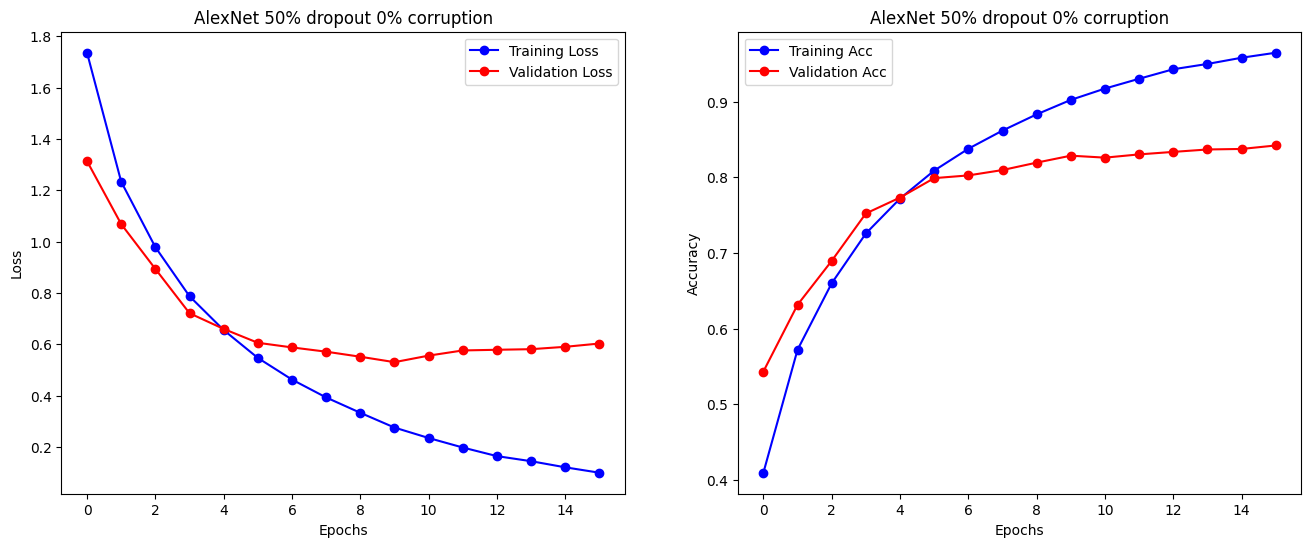

In [ ]:
plot_losses(train_losses, valid_losses, train_accs, valid_accs, "AlexNet 50% dropout 0% corruption")

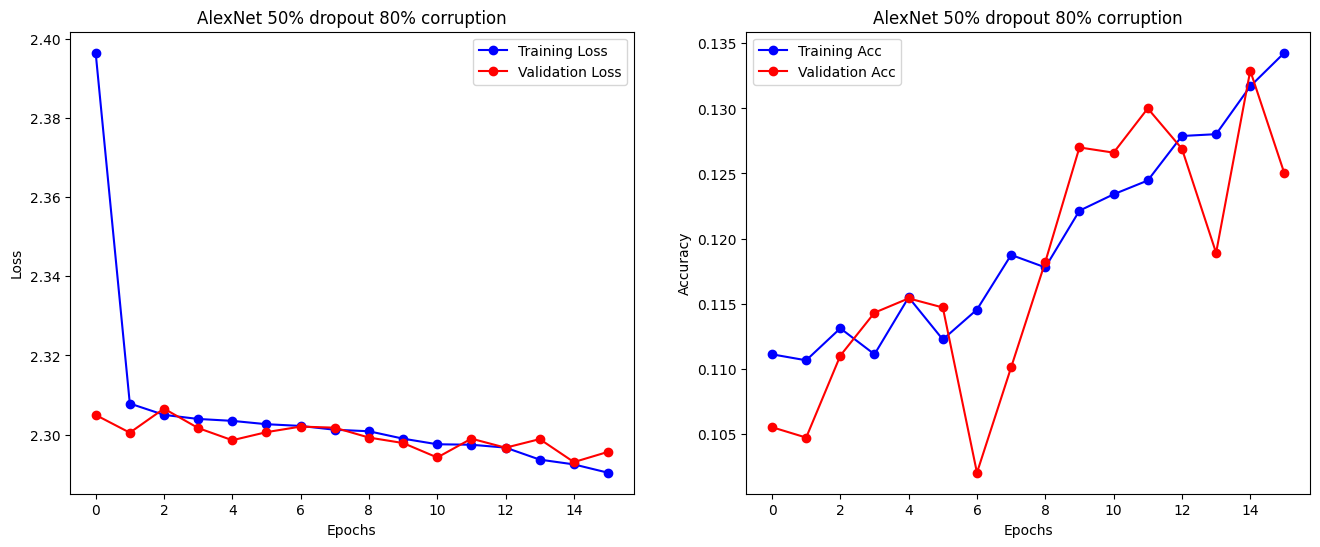

In [ ]:
plot_losses(train_lossesCor, valid_lossesCor, train_accsCor, valid_accsCor, "AlexNet 50% dropout 80% corruption")

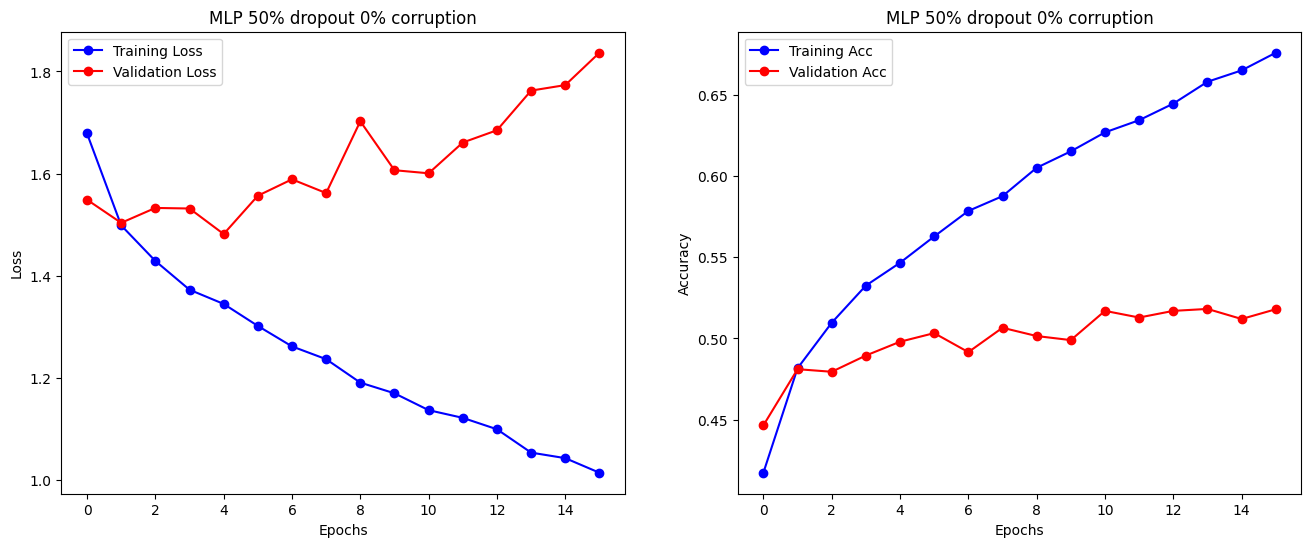

In [ ]:
plot_losses(MLPtrain_losses, MLPvalid_losses, MLPtrain_accs, MLPvalid_accs, "MLP 50% dropout 0% corruption")

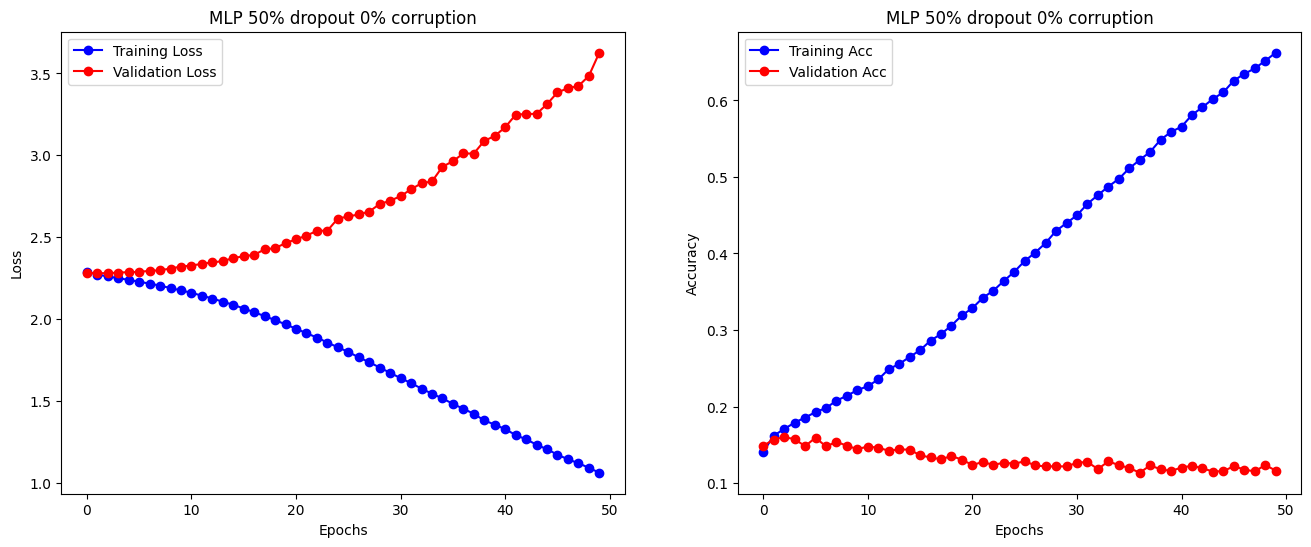

In [ ]:
plot_losses(MLPtrain_lossesCor, MLPvalid_lossesCor, MLPtrain_accsCor, MLPvalid_accsCor, "MLP 50% dropout 0% corruption")

In [ ]:
plot_losses(train_lossesPTAN, valid_lossesPTAN, train_accsPTAN, valid_accsPTAN, "PTAN (80% corrpution) AlexNet 50% dropout ")

In [ ]:
total_params = sum(p.numel() for p in alexnet.parameters())
print(f"Total number of parameters: {total_params}")

In [ ]:
total_params = sum(p.numel() for p in mlp.parameters())
print(f"Total number of parameters: {total_params}")